In [22]:
using Lux, Reactant, Enzyme, Zygote, Optimisers, MLUtils, Random, Statistics, JLD2, Plots, NNlib, ProgressMeter, BSON
include("analysis_tools.jl")

const cdev = cpu_device()
const xdev = reactant_device(; force=true);

In [23]:
# Settings
epochs = 1000
batchsize = 40
learning_rate = 0.005f0

seed = 0
#ad_backend = AutoZygote() # Reactant does not like zygote, cpu does not like enzyme
ad_backend = AutoEnzyme()

n_in = 1
n_out = 1
n_hidden = 8
n_filter = 3;

In [24]:
# data1=load("data/burgers1d_periodic_dt.jld2")
# data2=load("data/burgers1d_periodic7.jld2")

# n_steps = length(data1["solution"])-1
# n_points = length(data1["solution"][1])

# X = zeros(Float32, n_points, 1, n_steps*2)
# y = zeros(Float32, n_points, 1, n_steps*2)
# for t in 1:n_steps
#     X[:,:,t] .= data1["solution"][t]
#     y[:,:,t] .= data1["solution"][t+1]
    
#     X[:,:,n_steps+t] .= data2["solution"][t]
#     y[:,:,n_steps+t] .= data2["solution"][t+1]
# end

data=load("data/burgers1d_periodicTEMP.jld2")
n_steps = length(data["solution"])-1
n_points = length(data["solution"][1])

X = zeros(Float32, n_points, 1, n_steps)
y = zeros(Float32, n_points, 1, n_steps)
for t in 1:n_steps
    X[:,:,t] .= data["solution"][t]
    y[:,:,t] .= data["solution"][t+1]
end

Xμ = mean(X)
Xσ = std(X)
X = (X .- Xμ) ./ Xσ
y = (y .- Xμ) ./ Xσ

dataloader = DataLoader((X, y), batchsize=batchsize, shuffle=true, partial=false) |> xdev;

In [25]:
n_pad = n_filter ÷ 2

model_residual = Chain(
    WrappedFunction(x -> pad_circular(x, n_pad; dims=1)),
    Conv((n_filter,), n_in=>n_hidden, swish),
    
    WrappedFunction(x -> pad_circular(x, n_pad; dims=1)),
    Conv((n_filter,), n_hidden=>n_hidden, swish),
    
    WrappedFunction(x -> pad_circular(x, n_pad; dims=1)),
    Conv((n_filter,), n_hidden=>n_hidden, swish),
    
    WrappedFunction(x -> pad_circular(x, n_pad; dims=1)),
    Conv((n_filter,), n_hidden=>n_out)
)

rnn = SkipConnection(model_residual, +);

In [26]:
function loss_function(model, ps, st, (X_batch, y_batch))
    smodel = StatefulLuxLayer(model, ps, st)
    y_pred = smodel(X_batch)
    data_loss = mean(abs2, y_pred .- y_batch)
    mass_loss = mean(abs2, mean(y_pred, dims=1) .- mean(y_batch, dims=1))
    loss = data_loss #+ mass_loss
    return loss, st, (; data_loss, mass_loss, total_loss=loss)
end;

In [27]:
rng = Random.default_rng()
Random.seed!(rng, seed)

ps, st = Lux.setup(rng, rnn) |> xdev

train_state = Training.TrainState(rnn, ps, st, Adam(learning_rate))

lr = i -> i < 500 ? 0.005f0 : (i < 1000 ? 0.0005f0 : 0.00005f0)

total_losses = Float32[]
data_losses = Float32[]
mass_losses = Float32[]

@showprogress for epoch in 1:epochs
    Optimisers.adjust!(train_state, lr(epoch))
    for batch in dataloader
        _, loss, stats, train_state = Training.single_train_step!(ad_backend,
                                                              loss_function,
                                                              batch,
                                                              train_state;
                                                              return_gradients=Val(false),
        )
        push!(total_losses, stats.total_loss)
        push!(data_losses, stats.data_loss)
        push!(mass_losses, stats.mass_loss)
    end
end

model = StatefulLuxLayer(rnn, cdev(train_state.parameters), cdev(train_state.states));
BSON.@save "models/trained_model_trial.bson" model Xμ Xσ n_pad;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


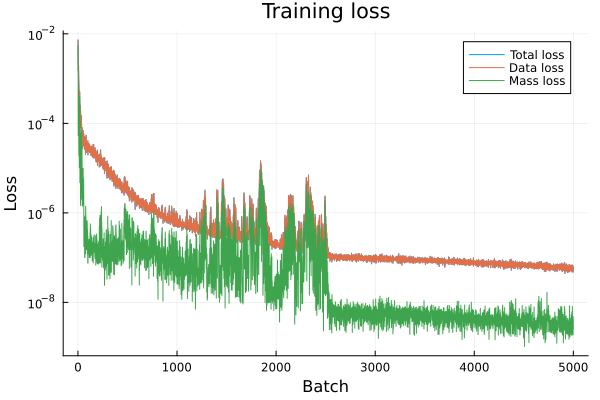

In [28]:
p1 = plot(total_losses, label="Total loss", xlabel="Batch", ylabel="Loss", yscale=:log10, title="Training loss")
plot!(p1, data_losses, label="Data loss")
plot!(p1, mass_losses, label="Mass loss")
display(p1)